In [ ]:
# Import library yang dibutuhkan
import pandas as pd # Make sure this line is executed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score,
    roc_auc_score, confusion_matrix
)

from sklearn.model_selection import train_test_split, GridSearchCV
import joblib  # untuk menyimpan model

In [ ]:
# Baca dataset
df = pd.read_csv('/content/Dataset2.csv')

# Tampilkan beberapa baris pertama
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [ ]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [ ]:
df.isnull().sum()

,0
user_id,0
signup_time,0
purchase_time,0
purchase_value,0
device_id,0
source,0
browser,0
sex,0
age,0
ip_address,0


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# Normalisasi kolom numerik (age, purchase_value)
scaler = StandardScaler()
df[['age', 'purchase_value']] = scaler.fit_transform(df[['age', 'purchase_value']])

# EDA

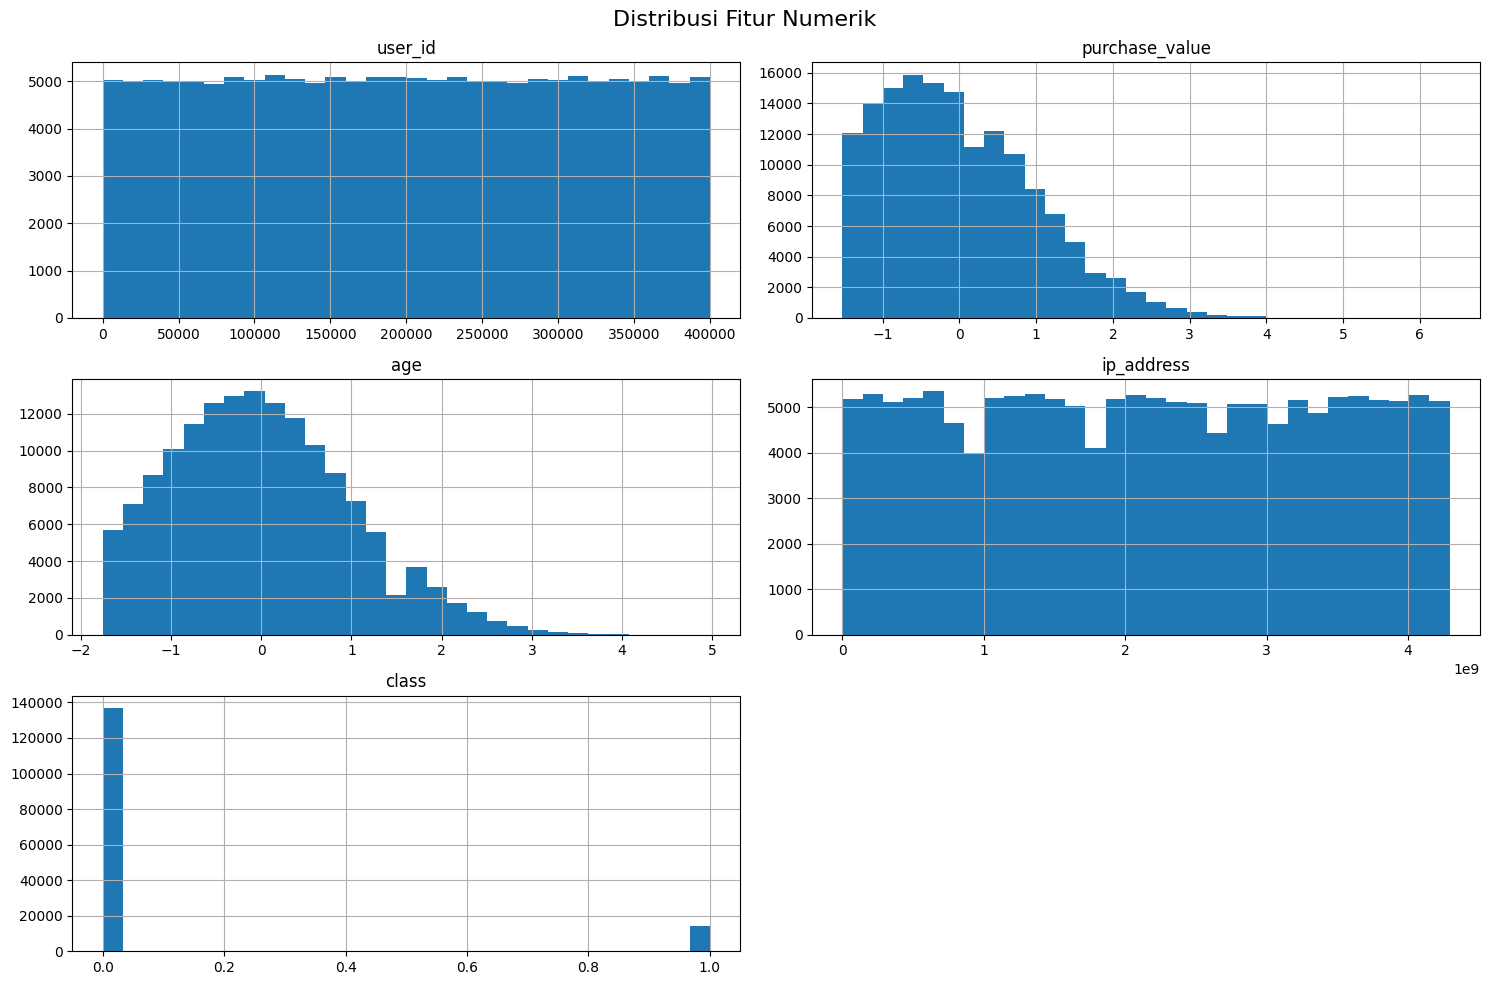

In [ ]:
# Plot distribusi fitur numerik
df.hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribusi Fitur Numerik', fontsize=16)
plt.tight_layout()
plt.show()

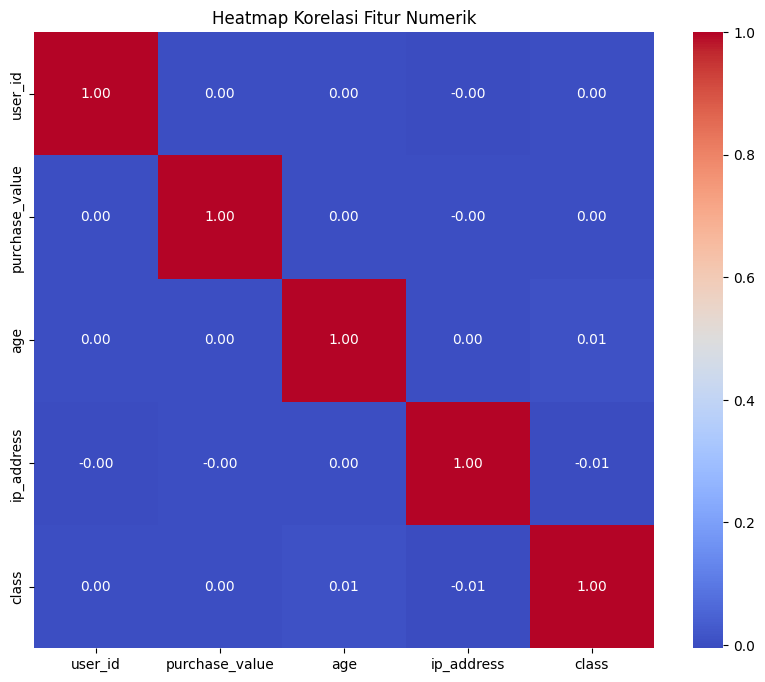

In [ ]:
# Korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

# Modeling

In [ ]:
# FEATURE ENGINEERING
# Feature Extraction
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['time_diff'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds()
df['signup_hour'] = df['signup_time'].dt.hour
df['purchase_hour'] = df['purchase_time'].dt.hour
df['purchase_dayofweek'] = df['purchase_time'].dt.dayofweek
df['value_per_age'] = df['purchase_value'] / (df['age'] + 1)
df['signup_to_purchase_hour'] = df['time_diff'] / 3600

df['age_group'] = pd.cut(df['age'], [17, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '50+'])
max_val = df['purchase_value'].max() if df['purchase_value'].max() > 100 else 200
df['value_group'] = pd.cut(df['purchase_value'], [0, 20, 50, 100, max_val + 1], labels=['low', 'medium', 'high', 'very high'])
df['signup_period'] = pd.cut(df['signup_hour'], [0, 6, 12, 18, 24], labels=['midnight', 'morning', 'afternoon', 'night'])

df['device_id'] = df['device_id'].astype(str)
df['device_freq'] = df['device_id'].map(df['device_id'].value_counts())
df['device_freq_flag'] = df['device_freq'].apply(lambda x: 1 if x > 50 else 0)

# --- 3. ONE-HOT ENCODING ---
# Cek kolom mana yang benar-benar tersedia di dataframe
target_cols = ['browser', 'source', 'sex', 'age_group', 'value_group', 'signup_period']
available_cols = [col for col in target_cols if col in df.columns]

# Jalankan one-hot encoding hanya untuk kolom yang tersedia
df = pd.get_dummies(df, columns=available_cols, drop_first=True)

# --- 4. MISSING VALUE ---
df.dropna(inplace=True)

# --- 5. TARGET & FITUR ---
y = df['class'].astype(int)
X = df.drop(columns=['user_id', 'signup_time', 'purchase_time', 'class', 'device_id'])

value_group_cols = [col for col in df.columns if 'value_group_' in col]
X_nb = X.copy()
X_rf = X.drop(columns=value_group_cols)

# --- 6. SCALING + SPLIT + SMOTE ---
scaler_nb = StandardScaler()
X_nb_scaled = scaler_nb.fit_transform(X_nb)
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(X_nb_scaled, y, test_size=0.2, random_state=42)
X_nb_train_sm, y_nb_train_sm = SMOTE(random_state=42).fit_resample(X_nb_train, y_nb_train)

scaler_rf = StandardScaler()
X_rf_scaled = scaler_rf.fit_transform(X_rf)
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf_scaled, y, test_size=0.2, random_state=42)
X_rf_train_sm, y_rf_train_sm = SMOTE(random_state=42).fit_resample(X_rf_train, y_rf_train)

# --- 7. TRAINING RANDOM FOREST ---
rf_model = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_split=5,
                                   min_samples_leaf=2, class_weight='balanced', random_state=42, n_jobs=-1)
rf_model.fit(X_rf_train_sm, y_rf_train_sm)
rf_preds = rf_model.predict(X_rf_test)

print("\n\U0001F7E9 Random Forest")
print(classification_report(y_rf_test, rf_preds))
print("Accuracy:", accuracy_score(y_rf_test, rf_preds))
print("ROC AUC:", roc_auc_score(y_rf_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_rf_test, rf_preds))

# --- 8. TRAINING NAIVE BAYES ---
nb_model = GaussianNB()
nb_model.fit(X_nb_train_sm, y_nb_train_sm)
nb_preds = nb_model.predict(X_nb_test)

print("\n\U0001F7E6 Naive Bayes")
print(classification_report(y_nb_test, nb_preds))
print("Accuracy:", accuracy_score(y_nb_test, nb_preds))
print("ROC AUC:", roc_auc_score(y_nb_test, nb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_nb_test, nb_preds))

# --- 9. SAVE MODEL ---
model_bundle = {
    'scaler_nb': scaler_nb,
    'scaler_rf': scaler_rf,
    'random_forest': rf_model,
    'naive_bayes': nb_model,
    'feature_columns_nb': X_nb.columns.tolist(),
    'feature_columns_rf': X_rf.columns.tolist()
}
joblib.dump(model_bundle, 'fraud_detection_models.pkl')



🟩 Random Forest
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27373
           1       0.76      0.61      0.68      2850

    accuracy                           0.95     30223
   macro avg       0.86      0.79      0.82     30223
weighted avg       0.94      0.95      0.94     30223

Accuracy: 0.9452403798431658
ROC AUC: 0.7932648512011773
Confusion Matrix:
 [[26841   532]
 [ 1123  1727]]

🟦 Naive Bayes
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27373
           1       0.78      0.56      0.65      2850

    accuracy                           0.94     30223
   macro avg       0.87      0.77      0.81     30223
weighted avg       0.94      0.94      0.94     30223

Accuracy: 0.9433543989676736
ROC AUC: 0.770533885035901
Confusion Matrix:
 [[26922   451]
 [ 1261  1589]]


['fraud_detection_models.pkl']